# Lexical Category Analysis with LIWC
A way to analyze any DTRS dataset using lexical categories from LIWC.
Uses the liwc library, [install from GitHub](https://github.com/evanll/liwc-text-analysis-python)

In [1]:
import sys
import re
import glob
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Markdown, display
from liwc import Liwc
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

## LIWC Dictionary
Unfortunately the different LIWC libraries don't appear to work with the `.dic` file. Ideally we need a text file or simply a list of related terms. Assuming the latter, we proceed.

In [2]:
nlp = spacy.load("en_core_web_sm")
# stop_list = stopwords.words('English')
#############THIS PART DOES NOT WORK! ##################
liwc = Liwc('./models/LIWC2015_English_Flat.dic')

In [3]:
def printmd(string):
    display(Markdown(string))

## Load DTRS datasets
Load pre-processed DTRS datasets into a dataframe

In [4]:
files = glob.glob('./output/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df.shape[0], "rows into the dataframe.")

Read 65 files and loaded 20902 rows into the dataframe.


In [5]:
df[0:10]

,dataset,session,speaker,utterance
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn."
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...
5,dtrs-10,grad-2-concept-review-sharon,Wilson,Let me take a look. Uh. So it is uh a coat h...
6,dtrs-10,grad-2-concept-review-sharon,Steve,"OK. It makes sense. Okay, what is good about..."
7,dtrs-10,grad-2-concept-review-sharon,Wilson,I think the storyboard it make very good sense.
8,dtrs-10,grad-2-concept-review-sharon,Steve,Okay.
9,dtrs-10,grad-2-concept-review-sharon,Wilson,Yes.


## Extract List of Terms from LIWC
The list below is a placeholder. Ideally we would like to replace the list below with a list of category terms from LIWC.

In [6]:
liwc_test = ["swim", "walk", "paddle", "ride", "crawl", "scoot", "paddling",
             "drag", "swim", "waddle", "gallop", "jump", "Swim", "feet", "fly",
             "pedal", "trail", "skate", "slip", "haul", "slide", "jog", "jog",
             "crawl", "climb_trees", "chase", "walk", "faceplant", "boat",
             "catch", "knuckle", "riding", "hike", "fling", "uphill",
             "snowboard", "swimming", "long_board", "float", "hop", "sprint",
             "raft", "bonk", "hike", "walk/run", "dismount", "mosey", "limp",
             "train", "scurry", "whack", "ditch", "skateboard", "duck", "kayak",
             "huck", "ski", "saunter", "wheel", "dart", "paddling", "sideways",
             "sail", "plow", "yank", "fly", "loaf", "dive", "head", "drive",
             "legs", "kayak", "town", "lumber", "lay", "step", "skateboard",
             "hump", "sit", "climb", "shimmy", "pound", "scoot", "trail", "zip",
             "soft_sand", "long_ride", "feet", "glide", "trudge", "deep_water",
             "skid", "strap", "beach", "putter", "maneuver"]

## Counting Relevant Terms in the Dataset
We count the number of terms in each utterance that also exist in the above list of category terms. This term count is added as a separate column (in this case called `liwc_test`).

In [7]:
def add_liwc_measure(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    liwc_measures = []
    for ind, utterance in enumerate(list(df['utterance'])) :
        if utterance != '' and utterance != ' ' :
            doc = nlp(utterance)
            tokens = [str(token) for token in doc if token.pos_ != "PUNCT"]
            liwc_measure_terms = [token for token in tokens if token in lex_category_list]
            liwc_measure = len(liwc_measure_terms)
            liwc_measures.append(liwc_measure)
    df.insert(column_index, lex_category_name, liwc_measures, True)
    return df


In [8]:
df = add_liwc_measure(df, 'liwc_test', liwc_test)
df[0:10]

,dataset,session,speaker,utterance,liwc_test
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?,0
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?,0
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn.",0
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?,0
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...,0
5,dtrs-10,grad-2-concept-review-sharon,Wilson,Let me take a look. Uh. So it is uh a coat h...,0
6,dtrs-10,grad-2-concept-review-sharon,Steve,"OK. It makes sense. Okay, what is good about...",0
7,dtrs-10,grad-2-concept-review-sharon,Wilson,I think the storyboard it make very good sense.,0
8,dtrs-10,grad-2-concept-review-sharon,Steve,Okay.,0
9,dtrs-10,grad-2-concept-review-sharon,Wilson,Yes.,0


In [9]:
def round_to_multiples(x, multiples_of=5):
    base = multiples_of
    if base == 0 :
        return base
    else :
        return base * round(x/base)
    
def round2(x):
    y = round(x, 2)
    return y

def plot_measure(df, dataset, session, measure):
    df0=df[df['dataset']==dataset]
    if session != '' :
        df1=df0[df0['session']==session]
    else :
        df1 = df0
    fig = plt.figure(figsize=[10,2], dpi=300)
    col = sns.color_palette("Set2")
    sns.set_style('ticks', {'axes.linewidth': 0.5, 'axes.edgecolor':'grey', 'axes.spinecolor' : 'grey'})
    sns.set_context('paper', font_scale = 1)
    ax = sns.barplot(x=df1.index, y=measure, data=df1, hue='speaker', palette ='Set2', linewidth=0)
    data_len = df1.shape[0]
    rounding_factor = int(data_len/50)
    xlim = df1.shape[0] + 1
    if rounding_factor > 0 :
        xlist = list(np.arange(0, xlim, round_to_multiples(xlim/20, multiples_of=rounding_factor)))
    else :
        xlist = list(np.arange(0, xlim))
    ax.set_xticks(xlist)
    ax.set_xticklabels(ax.get_xticks(), fontsize=7)
    ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)
    ax.set_ylabel(measure, fontsize=9)
    plt.title("# words vs. # utterances: " + dataset +' | '+ session +' | '+ measure, fontsize=9)
    speakers = len(set(list(df1['speaker'])))
    legend_columns = round(speakers/4) + 1
    plt.legend(loc='best', ncol=legend_columns, borderaxespad=0.15)
    plt.savefig('./plots/'+ dataset +'-'+ session +'-'+ measure +'.pdf', bbox_inches='tight')

In [10]:
def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')

## Dataset Information as Reference for Plotting
Down below you will see a table of all datasets and sessions. You can use them as inputs to plot the lexical categories for any one dataset and session.

In [11]:
df_data = df.drop(['speaker', 'utterance', 'liwc_test'], axis=1)
df_data = df_data.drop_duplicates(subset=None, keep='first', inplace=False)
df_data = df_data.reset_index()
df_data[df_data['dataset'] == 'dtrs-02'].sort_values('session')

,index,dataset,session
52,16295,dtrs-02,think-aloud
31,9231,dtrs-02,three-person-discussion


In [12]:
df_data[df_data['dataset'] == 'dtrs-07'].sort_values('session')

,index,dataset,session
10,1597,dtrs-07,crematorium-meeting-01
12,2619,dtrs-07,crematorium-meeting-02
55,17060,dtrs-07,engineers-meeting-01
61,19574,dtrs-07,engineers-meeting-02


In [13]:
df_data[df_data['dataset'] == 'dtrs-10'].sort_values('session')

,index,dataset,session
7,740,dtrs-10,grad-1-search-review-amie-jin
6,461,dtrs-10,grad-1-search-review-marlen-david
14,3950,dtrs-10,grad-1-search-review-sharon-ellen
58,18589,dtrs-10,grad-2-concept-review-amie
41,13182,dtrs-10,grad-2-concept-review-ellen
48,16058,dtrs-10,grad-2-concept-review-marlen
0,0,dtrs-10,grad-2-concept-review-sharon
9,1142,dtrs-10,grad-2-concept-review-wilson
3,319,dtrs-10,grad-3-client-review-ellen
40,13098,dtrs-10,grad-3-client-review-jin


In [14]:
df_data[df_data['dataset'] == 'dtrs-11'].sort_values('session')

,index,dataset,session
39,12996,dtrs-11,01-background-interview
36,12730,dtrs-11,02-designing-cocreation-workshops
34,11701,dtrs-11,03-iterations-on-workshop-design
21,6202,dtrs-11,04-iterations-on-cocreation-workshops
15,4184,dtrs-11,05-designing-cocreation-workshops-day-2
30,9071,dtrs-11,07-designing-cocreation-workshops-debrief-day-1
45,14696,dtrs-11,08-sharing-insights-from-cocreation-workshops-...
35,12256,dtrs-11,09-clustering-insights-cc1
28,8421,dtrs-11,10-iterations-on-cc2-design
46,15036,dtrs-11,11-linking-insights-from-cc-to-project


## Plot Occurrences
Plot Lexical categories for any dataset and session.

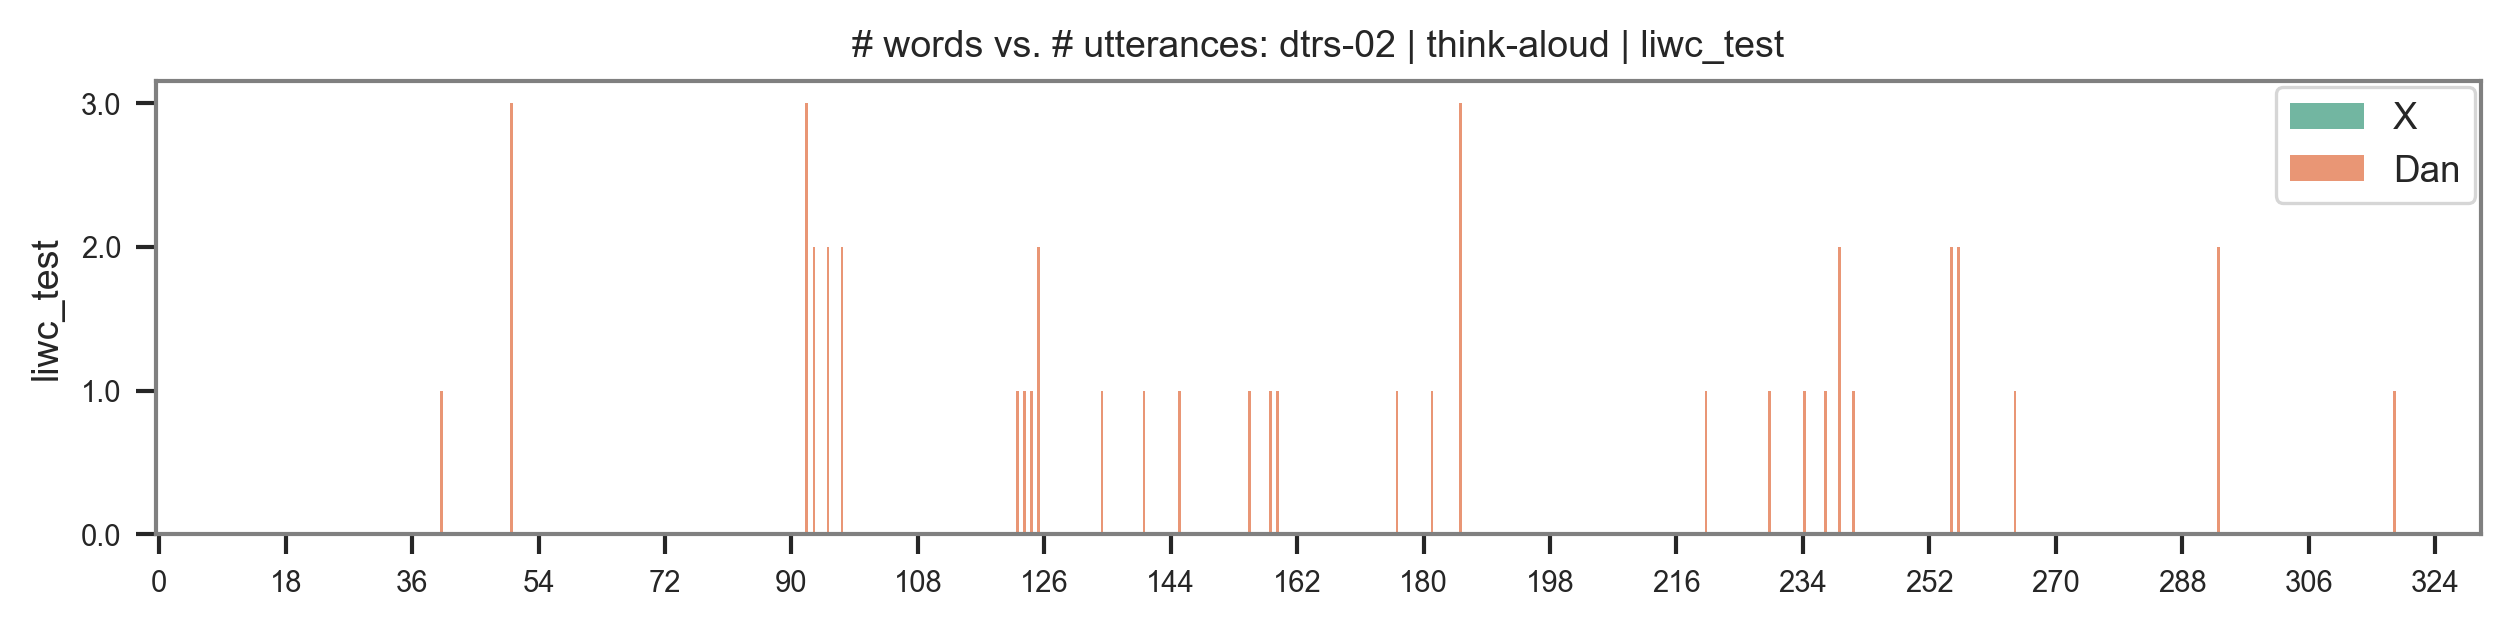

In [15]:
plot_measure(df, 'dtrs-02', 'think-aloud', 'liwc_test')

## Examine Specifics
Examine utterances in detail and show overlaps with terms in the lexical category.

In [16]:
print_lines(df, 'dtrs-02', 'think-aloud', liwc_test_list, 90, num_lines=5)

NameError: name 'liwc_test_list' is not defined